# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_gemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/standardised_essentia_best_overall_opensmile_gemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_gemaps_features = df_essentia_best_overall_opensmile_gemaps_features[df_essentia_best_overall_opensmile_gemaps_features.columns[1:]]

df_essentia_best_overall_opensmile_gemaps_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,2,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,...,0.287564,-0.262130,-0.181091,0.668531,-0.555169,-0.967327,-0.075432,0.439999,-0.440097,-0.377481
1,3,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,...,-1.745983,1.481523,-1.835793,0.496337,-0.932362,0.263018,-0.389877,-0.474327,0.570241,0.450156
2,4,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,...,0.025746,-0.164946,-0.758607,0.719491,0.005327,0.196521,-0.381856,-0.512572,-0.174826,-0.303339
3,5,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,...,0.296808,-0.540060,1.453477,-1.260938,-0.603349,-1.000287,-0.015498,0.340968,-0.418676,-0.300240
4,7,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,...,-2.342634,1.977728,-0.823529,0.440421,1.121683,-0.917488,-0.139595,0.293586,-0.372262,-0.240131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,...,0.343948,-0.753080,0.230580,-0.884061,1.768270,-0.434687,-0.329498,-0.316919,-0.508329,-0.462869
1740,1997,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,...,0.222617,-0.444289,0.247618,-0.770541,1.076880,-0.550845,-0.310073,-0.300887,-0.344771,-0.226950
1741,1998,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,...,0.374784,-0.346391,-0.400532,-0.131125,1.027496,0.996925,-0.404940,-0.493444,-0.080049,-0.197836
1742,1999,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,...,0.146768,-0.269664,0.058214,-0.166695,0.138567,0.629971,-0.396049,-0.541690,-0.219187,-0.239845


In [4]:
df_essentia_best_overall_opensmile_gemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 199 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.dmean                float64
 2    lowlevel.melbands_kurtosis.dmean2               float64
 3    lowlevel.melbands_kurtosis.dvar                 float64
 4    lowlevel.melbands_kurtosis.dvar2                float64
 5    lowlevel.melbands_kurtosis.max                  float64
 6    lowlevel.melbands_kurtosis.mean                 float64
 7    lowlevel.melbands_kurtosis.median               float64
 8    lowlevel.melbands_kurtosis.min                  float64
 9    lowlevel.melbands_kurtosis.stdev                float64
 10   lowlevel.melbands_kurtosis.var                  float64
 11   lowlevel.melbands_skewness.dmean                float64
 12   lowlevel.melbands_

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_gemaps_whole = pd.merge(df_essentia_best_overall_opensmile_gemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_gemaps_whole = df_essentia_best_overall_opensmile_gemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_gemaps_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,valence_mean_mapped,arousal_mean_mapped
0,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,-0.026304,...,-0.181091,0.668531,-0.555169,-0.967327,-0.075432,0.439999,-0.440097,-0.377481,-0.475,-0.500
1,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,-0.025526,...,-1.835793,0.496337,-0.932362,0.263018,-0.389877,-0.474327,0.570241,0.450156,-0.375,-0.425
2,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,-0.026786,...,-0.758607,0.719491,0.005327,0.196521,-0.381856,-0.512572,-0.174826,-0.303339,0.175,0.125
3,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,-0.026850,...,1.453477,-1.260938,-0.603349,-1.000287,-0.015498,0.340968,-0.418676,-0.300240,-0.150,0.075
4,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,-0.023528,...,-0.823529,0.440421,1.121683,-0.917488,-0.139595,0.293586,-0.372262,-0.240131,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,-0.026911,...,0.230580,-0.884061,1.768270,-0.434687,-0.329498,-0.316919,-0.508329,-0.462869,-0.275,0.225
1740,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,-0.026903,...,0.247618,-0.770541,1.076880,-0.550845,-0.310073,-0.300887,-0.344771,-0.226950,0.075,-0.275
1741,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,-0.026783,...,-0.400532,-0.131125,1.027496,0.996925,-0.404940,-0.493444,-0.080049,-0.197836,0.350,0.300
1742,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,-0.026830,...,0.058214,-0.166695,0.138567,0.629971,-0.396049,-0.541690,-0.219187,-0.239845,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_gemaps_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,-0.026304,...,0.287564,-0.262130,-0.181091,0.668531,-0.555169,-0.967327,-0.075432,0.439999,-0.440097,-0.377481
1,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,-0.025526,...,-1.745983,1.481523,-1.835793,0.496337,-0.932362,0.263018,-0.389877,-0.474327,0.570241,0.450156
2,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,-0.026786,...,0.025746,-0.164946,-0.758607,0.719491,0.005327,0.196521,-0.381856,-0.512572,-0.174826,-0.303339
3,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,-0.026850,...,0.296808,-0.540060,1.453477,-1.260938,-0.603349,-1.000287,-0.015498,0.340968,-0.418676,-0.300240
4,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,-0.023528,...,-2.342634,1.977728,-0.823529,0.440421,1.121683,-0.917488,-0.139595,0.293586,-0.372262,-0.240131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,-0.026911,...,0.343948,-0.753080,0.230580,-0.884061,1.768270,-0.434687,-0.329498,-0.316919,-0.508329,-0.462869
1740,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,-0.026903,...,0.222617,-0.444289,0.247618,-0.770541,1.076880,-0.550845,-0.310073,-0.300887,-0.344771,-0.226950
1741,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,-0.026783,...,0.374784,-0.346391,-0.400532,-0.131125,1.027496,0.996925,-0.404940,-0.493444,-0.080049,-0.197836
1742,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,-0.026830,...,0.146768,-0.269664,0.058214,-0.166695,0.138567,0.629971,-0.396049,-0.541690,-0.219187,-0.239845


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 300

Define the neural network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [13]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 198])


Training loop

In [14]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [15]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5919856661063264
Epoch 2, Loss: 0.5890659989877897
Epoch 3, Loss: 0.5862917020236218
Epoch 4, Loss: 0.5837528190708093
Epoch 5, Loss: 0.5814122229999482
Epoch 6, Loss: 0.5792679700373092
Epoch 7, Loss: 0.5773848615779948
Epoch 8, Loss: 0.5758207641459014
Epoch 9, Loss: 0.574334995674005
Epoch 10, Loss: 0.57293724254304
Epoch 11, Loss: 0.5716229628612757
Epoch 12, Loss: 0.5704399384552743
Epoch 13, Loss: 0.5693331893409633
Epoch 14, Loss: 0.5682908898480724
Epoch 15, Loss: 0.5673503242685392
Epoch 16, Loss: 0.566478145903395
Epoch 17, Loss: 0.5656564419263835
Epoch 18, Loss: 0.5648823198628004
Epoch 19, Loss: 0.5642465655670637
Epoch 20, Loss: 0.5636292090496735
Epoch 21, Loss: 0.5630369802224562
Epoch 22, Loss: 0.5624857741782257
Epoch 23, Loss: 0.5620770983942835
Epoch 24, Loss: 0.5616586804270246
Epoch 25, Loss: 0.5612376140765565
Epoch 26, Loss: 0.5608030258971846
Epoch 27, Loss: 0.56034307729387
Epoch 28, Loss: 0.5598339904224068
Epoch 29, Loss: 0.5592543157463001


## Neural Network Testing

Prepare input_test_data and target_test_labels

In [16]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 198])


Generating scores

In [17]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [18]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.2576766538309106
Test R^2 score: 0.28601930995132696


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 4.8438e-02,  1.3422e-01],
        [-2.1536e-01, -1.4485e-01],
        [ 5.4178e-01,  5.1793e-01],
        [ 2.5567e-01,  2.9125e-01],
        [-4.1663e-02, -2.9653e-01],
        [-2.4227e-01, -3.5063e-01],
        [-4.0734e-01, -4.7899e-01],
        [ 2.7611e-01,  2.9969e-01],
        [-2.4187e-01, -3.1090e-01],
        [ 1.1935e-01,  1.5500e-01],
        [ 2.8012e-01,  3.0446e-01],
        [-5.5996e-02,  3.4543e-02],
        [-2.4864e-01, -3.6557e-01],
        [ 5.3878e-01,  5.1481e-01],
        [-2.4036e-01, -1.6465e-01],
        [-1.6931e-02, -2.3520e-01],
        [-4.5131e-01, -5.0976e-01],
        [-2.5728e-01, -3.7081e-01],
        [ 2.9222e-01,  3.1103e-01],
        [-3.2280e-01, -4.2002e-01],
        [-4.0450e-01, -4.7588e-01],
        [-9.4189e-02, -1.2169e-01],
        [-2.4000e-01, -1.9356e-01],
        [ 3.3593e-01,  3.4089e-01],
        [ 2.0441e-02, -1.3836e-01],
        [-3.4059e-02, -3.1387e-01],
        [ 1.7155e-01,  2.2642e-01],
        [-4.8202e-02,  7.810

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5937800399810507
Training completed.
Training completed.
Testing model...
Test RMSE: 0.35452848880056964
Test R^2 score: -0.36602040368659494
Num of epochs: 2
Epoch 1, Loss: 0.5711606133975731
Epoch 2, Loss: 0.5689570113084879
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3104160114164725
Test R^2 score: -0.0525073900299845
Num of epochs: 3
Epoch 1, Loss: 0.5831201084173026
Epoch 2, Loss: 0.581164207074593
Epoch 3, Loss: 0.5792800859730892
Training completed.
Training completed.
Testing model...
Test RMSE: 0.33527792232098863
Test R^2 score: -0.24252575767042395
Num of epochs: 4
Epoch 1, Loss: 0.5746265961162448
Epoch 2, Loss: 0.572735043838687
Epoch 3, Loss: 0.5709697646204642
Epoch 4, Loss: 0.5693314095737481
Training completed.
Training completed.
Testing model...
Test RMSE: 0.31390649661380526
Test R^2 score: -0.06905817392914027
Num of epochs: 5
Epoch 1, Loss: 0.5643863308467213
Epoch 2, Loss: 0.5630711463893573
Epoch 3, Lo

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.36602040368659494,
 -0.0525073900299845,
 -0.24252575767042395,
 -0.06905817392914027,
 -0.04821156181738773,
 -0.04903012202086254,
 -0.10518717046527304,
 -0.07919195349137242,
 -0.16257440605503515,
 -0.006492499076157787,
 -0.09902294404843393,
 -0.14442986025703008,
 -0.037702182567893705,
 -0.04599577528197929,
 -0.026426265948142125,
 -0.07838428787310725,
 -0.003945783343389131,
 -0.005236659441914648,
 -0.15624500963519972,
 -0.009408584576971024,
 -0.02280430351356888,
 0.0016060845340539198,
 -0.005777301273682922,
 -0.008927439518905567,
 -0.00272775384404611,
 0.00317436608412508,
 0.007713634862911822,
 0.06423003630458013,
 -0.015954426310469283,
 0.021369056041318113,
 0.006400275807526334,
 0.005779184060019593,
 0.09822127901911942,
 0.016312948959951,
 0.07569099231327808,
 0.08405374365024093,
 0.19314726837438823,
 0.1286870043479032,
 0.28225364998932306,
 0.11915902827526781,
 0.05539345631621556,
 0.029990506413105744,
 0.22213012326574005,
 0.16073319864186

Plot the line graph

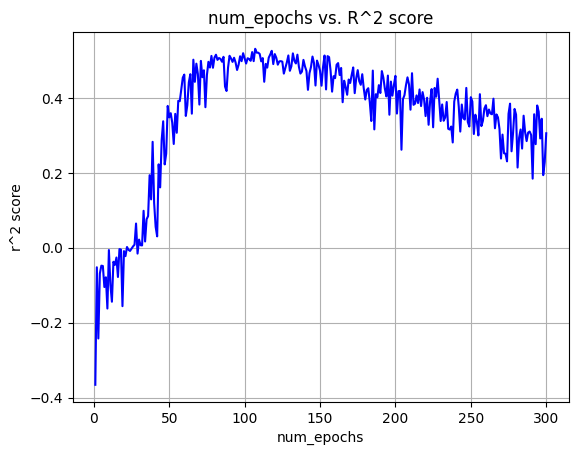

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5305071515355861
Corresponding RMSE: 0.20825765651948547
Corresponding num_epochs: 107
